This notebook is taking a dataset from Kaggle to predict House Prices. The dataset has 79 features, and one target. The target is a continuous value, so we will use regression techniques to predict the sale price. While there are a lot of options for Statistical Learning models to apply here, I will use TensorFlow and Keras for this project, and optimize a Neural Network.

# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

from tensorflow.keras import Sequential, metrics, layers

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Useful Functions
These are functions I have used in other projects to help expedite my EDA and model tuning and interpretation

In [3]:
# Plotting the history from a Keras model
def plot_history(history):
    """Plots the learning history from a Keras model and plots each metric"""
    metrics = history.history.keys()

    for i in metrics:
        if not 'val' in i:
            plt.plot(history.history[f'{i}'], label = f'{i}')
            if f'val_{i}' in metrics:
                plt.plot(history.history[f'val_{i}'], label = f'val_{i}')
            plt.legend()
            plt.title(f'{i}')
            plt.show()
            
# Scoring a Regression model and storing the values in a dataframe
def model_eval(model, X_train, y_train, X_test, y_test, name = 'Model'):
    """Saves the model scores into a dataframe that can be used to append to a master
    score dataframe later"""
    # Saving predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)
    
    # Scoring and saving to a dataframe
    scores = pd.DataFrame()
    
    # Training
    scores.loc[name, 'Training MAE'] = mean_absolute_error(y_train, train_preds)
    scores.loc[name, 'Training MSE'] = mean_squared_error(y_train, train_preds)
    scores.loc[name, 'Training R2'] = r2_score(y_train, train_preds)
    
    # Testing
    scores.loc[name, 'Testing MAE'] = mean_absolute_error(y_test, test_preds)
    scores.loc[name, 'Testing MSE'] = mean_squared_error(y_test, test_preds)
    scores.loc[name, 'Testing R2'] = r2_score(y_test, test_preds)
    
    return scores

# Importing Data

In [4]:
df = pd.read_csv('DataFiles/train.csv')
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

We have a lot of categorical data and some integer data. Luckily this dataset includes a .txt that explains the columns and their values. At first glance, it looks like we need to drop PoolQC, MiscFeature, FireplaceQu, Fence, and Alley. These columns have values for less than 50% of the rows. Accoring to the .txt file, all the null values represent NOT having either Alley access or a pool. Lets keep these columns and cut the dummy out of the feature matrix when one hot encoding. 

In [6]:
df.drop(columns = ['Id'], inplace = True)

I have some numeric columns with empty values that i need to fix. Most I'll fill with 0, but year I will change to a categorical column and fill the nulls with na

In [7]:
df['GarageYrBlt'] = df['GarageYrBlt'].map(str)

In [8]:
df['Electrical'].value_counts(normalize = True)

SBrkr    0.914325
FuseA    0.064428
FuseF    0.018506
FuseP    0.002056
Mix      0.000685
Name: Electrical, dtype: float64

Because Electrical has one missing value, and most values for electrical are SBrkr, I feel safe to use fillna here. 

In [9]:
df['Electrical'].fillna('SBrkr', inplace = True)

# Validation Split
First things first, lets split our data into train and test

In [10]:
X = df.drop('SalePrice', axis = 1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# Preprocessor
Now I will work on the preprocessor to create a processed array for the neural net

In [11]:
# imputers
cat_const = SimpleImputer(strategy = 'constant', fill_value = 'na')
num_const = SimpleImputer(strategy = 'constant', fill_value = 0)

# Transformers
ohe = OneHotEncoder(sparse = False, handle_unknown = 'ignore')
scaler = StandardScaler()

# Impute/Transform Pipelines
cat_pipe = make_pipeline(cat_const, ohe)
num_pipe = make_pipeline(num_const, scaler)

# Column Selectors
cat_cols = make_column_selector(dtype_include = 'object')
num_cols = make_column_selector(dtype_include = 'number')

# Tuples
cat_tuple = (cat_pipe, cat_cols)
num_tuple = (num_pipe, num_cols)

# Preprocessor
preprocessor = make_column_transformer(cat_tuple, num_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='na',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000222886A99D0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000222886A9A60>)])

In [12]:
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (1095, 393)
Testing shape: (365, 393)


We now have our data ready to pass through a model.

# Creating the Models

## Model 1

In [13]:
# Setting the input size to the size of the Training Data
input_shape = X_train.shape[1]

# Creating instances of my metrics
mae = metrics.MeanAbsoluteError()
rmse = metrics.RootMeanSquaredError()

model = Sequential()

# Creating my layers
model.add(layers.Dense(200, activation = 'relu', input_dim = input_shape))
model.add(layers.Dropout(.15))
model.add(layers.Dense(100, activation = 'relu'))
model.add(layers.Dense(100, activation = 'relu'))
model.add(layers.Dense(50, activation = 'relu'))
model.add(layers.Dense(25, activation = 'relu'))
model.add(layers.Dense(1, activation = 'linear'))

model.compile(optimizer = 'adam', loss = 'mse', metrics = [mae,rmse])

In [14]:
history = model.fit(X_train, y_train, epochs = 200, validation_data = (X_test, y_test),
                    verbose = 0)

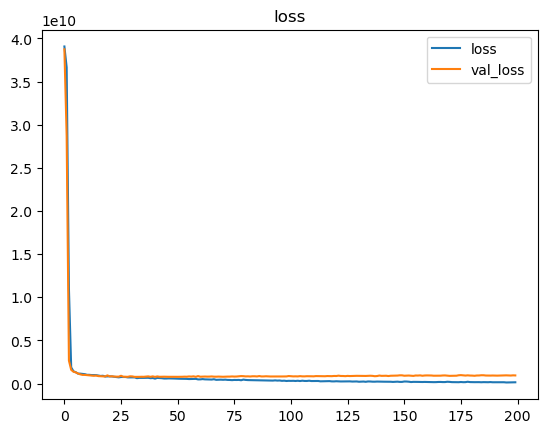

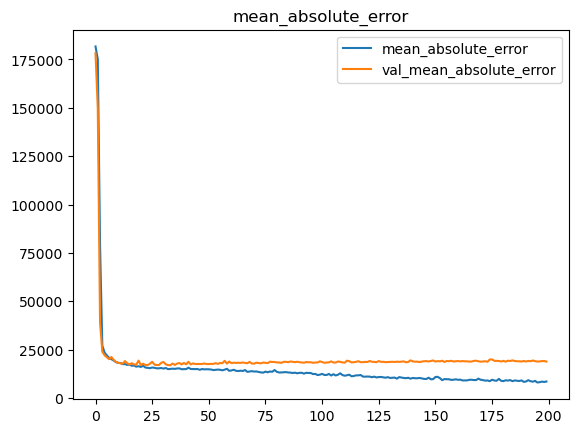

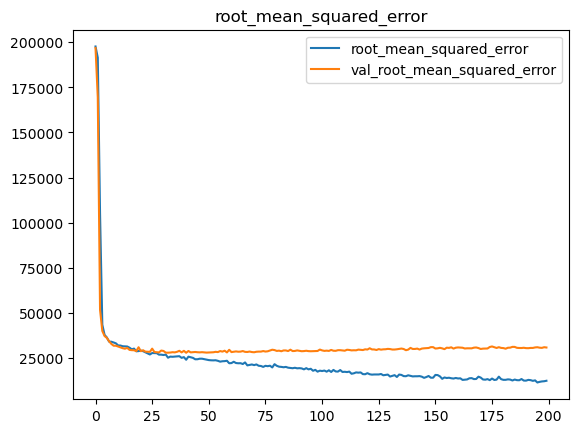

In [15]:
plot_history(history)